## 7-3. HHLアルゴリズムを用いたポートフォリオ最適化
この節では論文[1]を参考に、過去の株価変動のデータから、最適なポートフォリオ（資産配分）を計算してみよう。
ポートフォリオ最適化は、[7-1節](7.1_quantum_phase_estimation_detailed.ipynb)で学んだHHLアルゴリズムを用いることで、従来より高速に解けることが期待されている問題の一つである。
今回は具体的に、GAFA (Google, Apple, Facebook, Amazon) の4社の株式に投資する際、どのような資産配分を行えば最も低いリスクで高いリターンを得られるかという問題を考える。

### 株価データ取得
まずは各社の株価データを取得する。

* GAFA 4社の日次データを用いる
* 株価データ取得のためにpandas_datareaderを用いてYahoo! Financeのデータベースから取得
* 株価はドル建ての調整後終値（Adj. Close）を用いる

In [1]:
# データ取得に必要なpandas, pandas_datareaderのインストール
# !pip install pandas pandas_datareader

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

In [3]:
# 銘柄選択
codes = ['GOOG', 'AAPL', 'FB', 'AMZN'] # GAFA

# 2017年の1年間のデータを使用
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2017, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df = data['Adj Close'] 

## 直近のデータの表示
display(df.tail())

Symbols,GOOG,AAPL,FB,AMZN
Date,,,,
2017-12-22,1060.119995,169.869110,177.199997,1168.359985
2017-12-26,1056.739990,165.559555,175.990005,1176.760010
2017-12-27,1049.369995,165.588669,177.619995,1182.260010
2017-12-28,1048.140015,166.054581,177.919998,1186.099976
2017-12-29,1046.400024,164.258896,176.460007,1169.469971


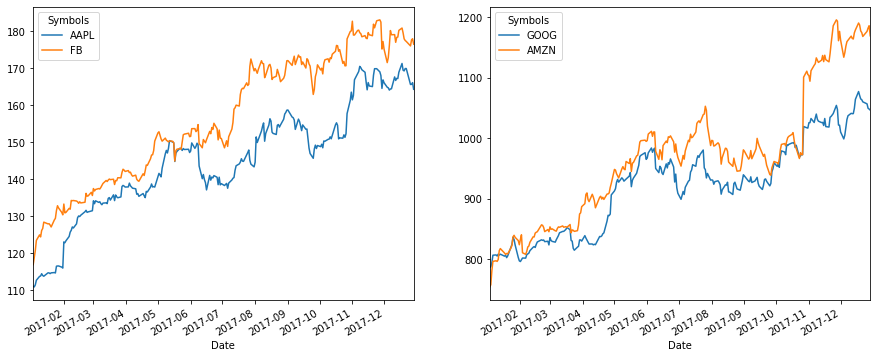

In [4]:
## 株価をプロットしてみる
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

※ここで、4つの銘柄を2つのグループに分けているのは、株価の値がそれぞれ近くプロット時に見やすいからであり、深い意味はない。

### データの前処理
次に、取得した株価を日次リターンに変換し、いくつかの統計量を求めておく。

#### 日次リターンへの変換
個別銘柄の日次リターン（変化率） $y_t$ （$t$は日付）は以下で定義される。 
$$
y_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$
これは `pandas DataFrame` の `pct_change()` メソッドで得られる。

In [5]:
daily_return = df.pct_change()
display(daily_return.tail())

Symbols,GOOG,AAPL,FB,AMZN
Date,,,,
2017-12-22,-0.003300,0.000000,-0.001409,-0.005448
2017-12-26,-0.003188,-0.025370,-0.006828,0.007190
2017-12-27,-0.006974,0.000176,0.009262,0.004674
2017-12-28,-0.001172,0.002814,0.001689,0.003248
2017-12-29,-0.001660,-0.010814,-0.008206,-0.014021


#### 期待リターン
銘柄ごとの期待リターン$\vec R$を求める。ここでは過去のリターンの算術平均を用いる： 
$$
\vec R = \frac{1}{T} \sum_{t= 1}^{T} \vec y_t
$$

In [6]:
expected_return = daily_return.dropna(how='all').mean() * 252 # 年率換算のため年間の営業日数252を掛ける
print(expected_return)

Symbols
GOOG    0.300215
AAPL    0.411192
FB      0.430156
AMZN    0.464567
dtype: float64


#### 分散・共分散行列
リターンの標本不偏分散・共分散行列$\Sigma$は以下で定義される。
$$
\Sigma = \frac{1}{T-1} \sum_{t=1}^{T} ( \vec y_t -\vec R ) (\vec y_t -\vec R )^T
$$

In [7]:
cov = daily_return.dropna(how='all').cov() * 252 # 年率換算のため
display(cov)

Symbols,GOOG,AAPL,FB,AMZN
Symbols,,,,
GOOG,0.023690,0.013303,0.018382,0.021614
AAPL,0.013303,0.031119,0.016291,0.018877
FB,0.018382,0.016291,0.028855,0.023337
AMZN,0.021614,0.018877,0.023337,0.044120


### ポートフォリオ最適化
準備が整ったところで、ポートフォリオ最適化に取り組もう。

まず、ポートフォリオ（i.e., 資産配分）を4成分のベクトル $\vec{w} = (w_0,w_1,w_2,w_3)^T$ で表す。
これは各銘柄を持つ割合（ウェイト）を表しており、例えば $\vec{w}=(1,0,0,0)$ であれば Google 株に全資産の100%を投入しするポートフォリオを意味する。

以下の式を満たすようなポートフォリオを考えてみよう。

$$
\min_{\vec{w}} \frac{1}{2} \vec{w}^T \Sigma \vec{w} \:\:\: \text{s.t.} \:\: \vec R^T \vec w = \mu , \: \vec 1^T \vec w =1
$$

この式は

* 「ポートフォリオの期待リターン（リターンの平均値）が$\mu$
* 「ポートフォリオに投資するウェイトの合計が1」（$\vec 1 = (1,1,1,1)^T$）

という条件の下で、

* 「ポートフォリオのリターンの分散の最小化」

を行うことを意味している。つまり、将来的に $\mu$ だけのリターンを望む時に、なるべくその変動（リスク）を小さくするようなポートフォリオが最善だというわけである。このような問題設定は、[Markowitzの平均分散アプローチ](https://ja.wikipedia.org/wiki/現代ポートフォリオ理論)と呼ばれ、現代の金融工学の基礎となる考えの一つである。

ラグランジュの未定乗数法を用いると、上記の条件を満たす$\vec{w}$は、線形方程式

$$
W\left ( 
\begin{array}{c}
\eta \\
\theta \\
\vec w
\end{array}
\right )
=
\left ( 
\begin{array}{c}
 \mu \\
 1 \\
\vec 0
\end{array}
\right ),\tag{1}
$$

$$ 
\\ W = \left ( 
\begin{array}{ccc} 0 & 0 & \vec R^T \\ 0 & 0 & \vec 1^T \\ \vec{R} &\vec 1 & \Sigma 
\end{array} \right ) 
$$

を解くことで得られる事がわかる。
ここで $\eta, \theta$ はラグランジュの未定乗数法のパラメータである。
したがって、最適なポートフォリオ $\vec w$ を求めるためには、連立方程式(1)を $\vec w$ について解けば良いことになる。
これで、ポートフォリオ最適化問題をHHLアルゴリズムが使える線形一次方程式に帰着できた。

#### 行列Wの作成

In [8]:
R = expected_return.values
Pi = np.ones(4)
S = cov.values

row1 = np.append(np.zeros(2), R).reshape(1,-1)
row2 = np.append(np.zeros(2), Pi).reshape(1,-1)
row3 = np.concatenate([R.reshape(-1,1), Pi.reshape(-1,1), S], axis=1)
W = np.concatenate([row1, row2, row3])

np.set_printoptions(linewidth=200)
print(W)

[[0.         0.         0.30021458 0.41119151 0.43015563 0.46456748]
 [0.         0.         1.         1.         1.         1.        ]
 [0.30021458 1.         0.02369003 0.01330333 0.01838175 0.0216144 ]
 [0.41119151 1.         0.01330333 0.03111917 0.01629131 0.01887668]
 [0.43015563 1.         0.01838175 0.01629131 0.02885482 0.02333747]
 [0.46456748 1.         0.0216144  0.01887668 0.02333747 0.04412049]]


In [9]:
## Wの固有値を確認 -> [-pi, pi] に収まっている
print(np.linalg.eigh(W)[0])

[-2.11207187 -0.10947986  0.01121933  0.01864265  0.11919724  2.20027702]


#### 右辺ベクトルの作成
以下でポートフォリオの期待リターン $\mu$ を指定すると、そのようなリターンをもたらす最もリスクの小さいポートフォリオを計算できる。$\mu$ は自由に設定できる。一般に期待リターンが大きいほどリスクも大きくなるが、ここでは例として10%としておく（GAFA株がガンガン上がっている時期なので、これはかなり弱気な方である）。

In [10]:
mu = 0.1 # ポートフォリオのリターン（手で入れるパラメータ）
xi = 1.0 
mu_xi_0 = np.append(np.array([mu, xi]), np.zeros_like(R)) ## (1)式の右辺のベクトル
print(mu_xi_0)

[0.1 1.  0.  0.  0.  0. ]


#### 量子系で扱えるように行列を拡張する
$W$ は6次元なので、3量子ビットあれば量子系で計算可能である ($2^3 = 8$)。
そこで、拡張した2次元分を0で埋めた行列とベクトルも作っておく。

In [11]:
nbit = 3 ## 状態に使うビット数
N = 2**nbit

W_enl = np.zeros((N, N)) ## enl は enlarged の略
W_enl[:W.shape[0], :W.shape[1]] = W.copy()
mu_xi_0_enl = np.zeros(N)
mu_xi_0_enl[:len(mu_xi_0)] = mu_xi_0.copy()

以上で、連立方程式(1)を解く準備が整った。

### HHLアルゴリズムを用いた最小分散ポートフォリオ算出
それでは、HHL アルゴリズムを用いて、連立一次方程式(1)を解いていこう。
先ずはその下準備として、

* 古典データ $\mathbf{x}$ に応じて、量子状態を $|0\cdots0\rangle \to \sum_i x_i |i \rangle$ と変換する量子回路を返す関数 `input_state_gate` （本来は qRAM の考え方を利用して作るべきだが、シミュレータを使っているので今回は non-unitary なゲートとして実装してしまう)
* 制御位相ゲートを返す関数 `CPhaseGate`
* 量子フーリエ変換を行うゲートを返す関数 `QFT_gate` 

を用意する。

In [12]:
# Qulacs のインストール
# !pip install qulacs

In [13]:
import numpy as np
from qulacs import QuantumCircuit, QuantumState, gate
from qulacs.gate import merge, Identity, H, SWAP

def input_state_gate(start_bit, end_bit, vec):
    """ 
    Making a quantum gate which transform |0> to \sum_i x[i]|i>m where x[i] is input vector.
    !!! this uses 2**n times 2**n matrix, so it is quite memory-cosuming.
    !!! this gate is not unitary (we assume that the input state is |0>)
    Args:
      int start_bit: first index of qubit which the gate applies 
      int end_bit:   last index of qubit which the gate applies
      np.ndarray vec:  input vector.
    Returns:
      qulacs.QuantumGate 
    """
    nbit = end_bit - start_bit + 1
    assert vec.size == 2**nbit
    mat_0tox = np.eye(vec.size, dtype=complex)
    mat_0tox[:,0] = vec
    return gate.DenseMatrix(np.arange(start_bit, end_bit+1), mat_0tox)


def CPhaseGate(target, control, angle):
    """ 
    Create controlled phase gate diag(1,e^{i*angle}) with controll. (Qulacs.gate is requried)

    Args:
      int target:  index of target qubit.
      int control:  index of control qubit.
      float64 angle: angle of phase gate.
    Returns:
      QuantumGateBase.DenseMatrix: diag(1, exp(i*angle)).
    """
    CPhaseGate = gate.DenseMatrix(target, np.array( [[1,0], [0,np.cos(angle)+1.j*np.sin(angle)]])  )
    CPhaseGate.add_control_qubit(control, 1)
    return CPhaseGate

def QFT_gate(start_bit, end_bit, Inverse = False):
    """ 
    Making a gate which performs quantum Fourier transfromation between start_bit to end_bit.
    (Definition below is the case when start_bit = 0 and end_bit=n-1)
    We associate an integer  j = j_{n-1}...j_0 to quantum state |j_{n-1}...j_0>.
    We define QFT as
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(2pi*i*(k/2^n)*j) |j>.
    then, |k_m > = 1/sqrt(2)*(|0> + exp(i*2pi*0.j_{n-1-m}...j_0)|1> )
    When Inverse=True,  the gate represents Inverse QFT,
    |k> = |k_{n-1}...k_0> = 1/sqrt(2^n) sum_{j=0}^{2^n-1} exp(-2pi*i*(k/2^n)*j) |j>.

    Args:
      int start_bit:  first index of qubits where we apply QFT.
      int end_bit:    last  index of qubits where we apply QFT.
      bool Inverse: When True, the gate perform inverse-QFT ( = QFT^{\dagger}).
    Returns:
      qulacs.QuantumGate: QFT gate which acts on a region between start_bit and end_bit.
    """

    gate = Identity(start_bit) ## make empty gate
    n = end_bit - start_bit + 1  ## size of QFT

    ## loop from j_{n-1} 
    for target in range(end_bit, start_bit-1, -1):
        gate = merge(gate, H(target)) ## 1/sqrt(2)(|0> + exp(i*2pi*0.j_{target})|1>)
        for control in range(start_bit, target):
            gate = merge( gate, CPhaseGate(target, control, (-1)**Inverse * 2.*np.pi/2**(target-control+1)) )
    ## perform SWAP between (start_bit + s)-th bit and (end_bit - s)-th bit
    for s in range(n//2):  ## s runs 0 to n//2-1
        gate = merge(gate, SWAP(start_bit + s, end_bit - s))
    ## return final circuit
    return gate

まずはHHLアルゴリズムに必要なパラメータを設定する。
クロックレジスタ量子ビット数 `reg_nbit`を `7` とし、行列 $W$ のスケーリングに使う係数 `scale_fac` を`1` とする（つまり、スケールさせない）。
また、制御回転ゲートに使う係数 $c$ は、`reg_nbit` ビットで表せる非ゼロの最も小さい数の半分にとっておく。

In [14]:
# 位相推定に使うレジスタの数
reg_nbit = 7

## W_enl をスケールする係数
scale_fac = 1.
W_enl_scaled = scale_fac * W_enl

## W_enl_scaledの固有値として想定する最小の値
## 今回は射影が100%成功するので, レジスタで表せる最小値の定数倍でとっておく
C = 0.5*(2 * np.pi * (1. / 2**(reg_nbit) ))

HHLアルゴリズムの核心部分を書いていく。今回は、シミュレータ qulacs を使うので様々な簡略化を行なっている。
HHLアルゴリズムがどのように動作するのかについての感覚を知る実装と思っていただきたい。

* 入力状態 $|\mathbf{b}\rangle$ を用意する部分は簡略化
* 量子位相推定アルゴリズムで使う $e^{iA}$ の部分は、 $A$ を古典計算機で対角化したものを使う
* 逆数をとる制御回転ゲートも、古典的に行列を用意して実装
* 補助ビット $|0\rangle_S$ への射影測定を行い、測定結果 `0` が得られた状態のみを扱う (実装の都合上、制御回転ゲートの定義を[7-1節](7.1_quantum_phase_estimation_detailed.ipynb)と逆にした）

In [15]:
from functools import reduce

## 対角化. AP = PD <-> A = P*D*P^dag 
D, P = np.linalg.eigh(W_enl_scaled)

#####################################
### HHL量子回路を作る. 0番目のビットから順に、Aの作用する空間のbit達 (0番目 ~ nbit-1番目), 
### register bit達 (nbit番目 ~ nbit+reg_nbit-1番目), conditional回転用のbit (nbit+reg_nbit番目)
### とする.
#####################################
total_qubits = nbit + reg_nbit + 1
total_circuit = QuantumCircuit(total_qubits)

## ------ 0番目~(nbit-1)番目のbitに入力するベクトルbの準備 ------
## 本来はqRAMのアルゴリズムを用いるべきだが, ここでは自作の入力ゲートを用いている. 
## qulacsではstate.load(b_enl)でも実装可能.
state = QuantumState(total_qubits)
state.set_zero_state() 
b_gate = input_state_gate(0, nbit-1, mu_xi_0_enl)
total_circuit.add_gate(b_gate)

## ------- レジスターbit に Hadamard gate をかける -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    total_circuit.add_H_gate(register)

## ------- 位相推定を実装 -------
## U := e^{i*A*t), その固有値をdiag( {e^{i*2pi*phi_k}}_{k=0, ..., N-1) )とおく.
## Implement \sum_j |j><j| exp(i*A*t*j) to register bits
for register in range(nbit, nbit+reg_nbit):
    ## U^{2^{register-nbit}} を実装.
    ## 対角化した結果を使ってしまう
    U_mat = reduce(np.dot,  [P, np.diag(np.exp( 1.j * D * (2**(register-nbit)) )), P.T.conj()]  )
    U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
    U_gate.add_control_qubit(register, 1) ## control bitの追加
    total_circuit.add_gate(U_gate)

## ------- Perfrom inverse QFT to register bits -------
total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=True))

## ------- conditional rotation を掛ける -------
## レジスター |phi> に対応するA*tの固有値は l = 2pi * 0.phi = 2pi * (phi / 2**reg_nbit).
## conditional rotationの定義は (本文と逆)
## |phi>|0> -> C/(lambda)|phi>|0> + sqrt(1 - C^2/(lambda)^2)|phi>|1>.
## 古典シミュレーションなのでゲートをあらわに作ってしまう.
condrot_mat = np.zeros( (2**(reg_nbit+1), (2**(reg_nbit+1))), dtype=complex)
for index in range(2**reg_nbit):
    lam = 2 * np.pi * (float(index) / 2**(reg_nbit) )
    index_0 = index ## integer which represents |index>|0>
    index_1 = index + 2**reg_nbit ## integer which represents |index>|1>
    if lam >= C:
        if lam >= np.pi: ## あらかじめ[-pi, pi]内に固有値をスケールしているので、[pi, 2pi] は 負の固有値に対応
            lam = lam - 2*np.pi
        condrot_mat[index_0, index_0] = C / lam
        condrot_mat[index_1, index_0] =   np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_0, index_1] = - np.sqrt( 1 - C**2/lam**2 )
        condrot_mat[index_1, index_1] = C / lam

    else:
        condrot_mat[index_0, index_0] = 1.
        condrot_mat[index_1, index_1] = 1.
## DenseGateに変換して実装
condrot_gate = gate.DenseMatrix(np.arange(nbit, nbit+reg_nbit+1), condrot_mat) 
total_circuit.add_gate(condrot_gate)

## ------- Perfrom QFT to register bits -------
total_circuit.add_gate(QFT_gate(nbit, nbit+reg_nbit-1, Inverse=False))

## ------- 位相推定の逆を実装(U^\dagger = e^{-iAt}) -------
for register in range(nbit, nbit+reg_nbit): ## from nbit to nbit+reg_nbit-1
    ## {U^{\dagger}}^{2^{register-nbit}} を実装.
    ## 対角化した結果を使ってしまう
    U_mat = reduce(np.dot,  [P, np.diag(np.exp( -1.j* D * (2**(register-nbit)) )), P.T.conj()]  )
    U_gate = gate.DenseMatrix(np.arange(nbit), U_mat)
    U_gate.add_control_qubit(register, 1) ## control bitの追加
    total_circuit.add_gate(U_gate)

## ------- レジスターbit に Hadamard gate をかける -------
for register in range(nbit, nbit+reg_nbit): 
    total_circuit.add_H_gate(register)

## ------- 補助ビットを0に射影する. qulacsでは非ユニタリゲートとして実装されている -------
total_circuit.add_P0_gate(nbit+reg_nbit)

#####################################
### HHL量子回路を実行し, 結果を取り出す
#####################################
total_circuit.update_quantum_state(state)

## 0番目から(nbit-1)番目の bit が計算結果 |x>に対応
result = state.get_vector()[:2**nbit].real
x_HHL = result/C * scale_fac

HHL アルゴリズムによる解 `x_HHL` と、通常の古典計算の対角化による解 `x_exact` を比べると、概ね一致していることが分かる。（HHLアルゴリズムの精度を決めるパラメータはいくつかある（例えば`reg_nbit`）ので、それらを変えて色々試してみて頂きたい。）

In [16]:
## 厳密解
x_exact = np.linalg.lstsq(W_enl, mu_xi_0_enl, rcond=0)[0]

print("HHL:  ", x_HHL)
print("exact:", x_exact)
rel_error = np.linalg.norm(x_HHL- x_exact) / np.linalg.norm(x_exact)
print("rel_error", rel_error)

HHL:   [ 0.09580738 -0.04980738  2.36660125  0.09900883 -0.47774813 -0.98438791  0.          0.        ]
exact: [ 0.15426894 -0.07338059  2.29996915  0.17711988 -0.66526695 -0.81182208  0.          0.        ]
rel_error 0.11097291393510306


実際のウェイトの部分だけ取り出すと

In [17]:
w_opt_HHL = x_HHL[2:6] 
w_opt_exact = x_exact[2:6] 
w_opt = pd.DataFrame(np.vstack([w_opt_exact, w_opt_HHL]).T, index=df.columns, columns=['exact', 'HHL'])
w_opt

,exact,HHL
Symbols,,
GOOG,2.299969,2.366601
AAPL,0.177120,0.099009
FB,-0.665267,-0.477748
AMZN,-0.811822,-0.984388


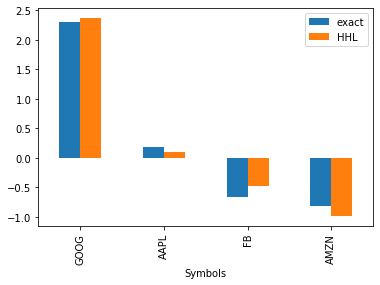

In [18]:
w_opt.plot.bar()

※重みが負になっている銘柄は、「空売り」（株を借りてきて売ること。株価が下がる局面で利益が得られる手法）を表す。今回は目標リターンが10%と、GAFA株（単独で30〜40%の期待リターン）にしてはかなり小さい値を設定したため、空売りを行って全体の期待リターンを下げていると思われる。

### Appendix: バックテスト
過去のデータから得られた投資ルールを、それ以降のデータを用いて検証することを「バックテスト」と呼び、その投資ルールの有効性を測るために重要である。
ここでは以上のように2017年のデータから構築したポートフォリオに投資した場合に、翌年の2018年にどの程度資産価値が変化するかを観察する。

In [19]:
# 2018年の1年間のデータを使用
start = datetime.datetime(2017, 12, 30)
end = datetime.datetime(2018, 12, 31)

# Yahoo! Financeから日次の株価データを取得
data = web.DataReader(codes, 'yahoo', start, end)

df2018 = data['Adj Close'] 

display(df2018.tail())

Symbols,GOOG,AAPL,FB,AMZN
Date,,,,
2018-12-24,976.219971,144.656540,124.059998,1343.959961
2018-12-26,1039.459961,154.843475,134.179993,1470.900024
2018-12-27,1043.880005,153.838562,134.520004,1461.640015
2018-12-28,1037.079956,153.917389,133.199997,1478.020020
2018-12-31,1035.609985,155.405045,131.089996,1501.969971


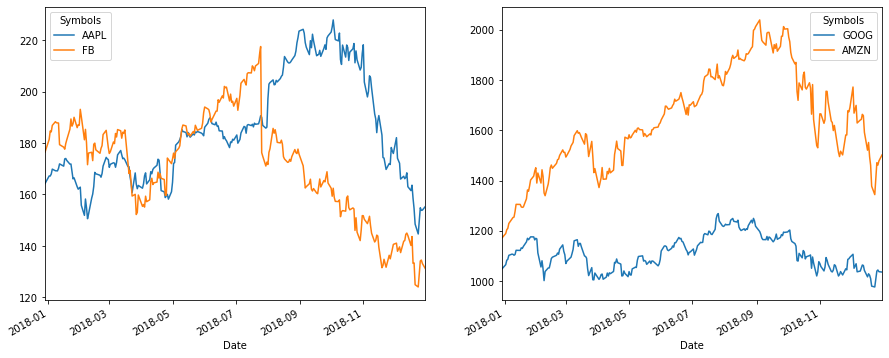

In [20]:
## 株価をプロットしてみる
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
df2018.loc[:,['AAPL', 'FB']].plot(ax=axes[0])
df2018.loc[:,['GOOG', 'AMZN']].plot(ax=axes[1])

In [21]:
# ポートフォリオの資産価値の推移
pf_value = df2018.dot(w_opt)
pf_value.head()

,exact,HHL
Date,,
2017-12-29,1368.986737,1257.159152
2018-01-02,1393.124262,1279.864457
2018-01-03,1418.828873,1304.724242
2018-01-04,1423.832841,1308.934869
2018-01-05,1443.032292,1326.138623


In [22]:
# exact と HHLで初期金額が異なることがありうるので、期初の値で規格化したリターンをみる。
pf_value.exact = pf_value.exact / pf_value.exact[0] 
pf_value.HHL = pf_value.HHL / pf_value.HHL[0] 
print(pf_value.tail())

               exact       HHL
Date                          
2018-12-24  0.801548  0.749625
2018-12-26  0.828918  0.766234
2018-12-27  0.841539  0.781597
2018-12-28  0.821053  0.756478
2018-12-31  0.805599  0.735876


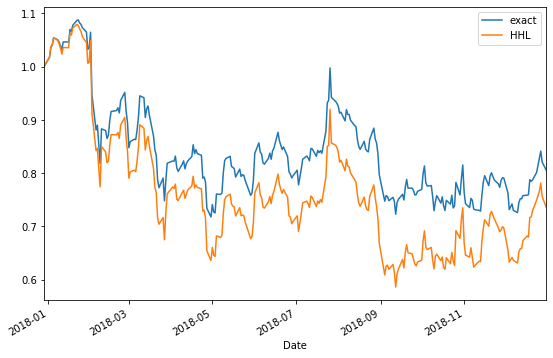

In [23]:
pf_value.plot(figsize=(9, 6))

2018年はGoogle以外のGAFA各社の株式が軟調だったので、およそ-20%もの損が出ているが、exact解の方は多少マシであるようだ。。
ちなみに、元々行ったのはリスク最小化なので、この一年間のリスクも計算してみると、exact解の方が小さい結果となった。

In [24]:
pf_value.pct_change().std() * np.sqrt(252) ## 年率換算

exact    0.402005
HHL      0.501925
dtype: float64

### 参考文献
[1] P. Rebentrost and S. Lloyd, "Quantum computational finance: quantum algorithm for portfolio optimization", https://arxiv.org/abs/1811.03975